In [1]:
### Import libraries and set plot style

import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from os import listdir
from cycler import cycler
import matplotlib.pyplot as plt
import matplotlib.transforms as trans
colors = ['#202020', '#d62728', '#1f77b4', '#2ca02c', '#ff7f0e', '#9467bd', '#bcbd22', '#e377c2', '#17becf', '#1f5a0a', '#8c564b', '#7f7f7f']
         ## black    red        blue       green      orange     violet     yellow     pink       lightblue  darkgreen  dirty-red  grey
plt.rcParams.update({'font.size': 7,
                     'axes.labelpad': 5,
                     'axes.labelsize': 8,
                     'xtick.labelsize' : 7,
                     'ytick.labelsize' : 7,
                     'axes.prop_cycle': cycler('color', colors),
                     #'axes.grid': True,
                     'axes.linewidth': 0.5,
                     'lines.linewidth': 0.5,
                     'lines.markersize': 2,
                     'scatter.marker': 'o',
                     #'errorbar.capsize': 2,
                     'figure.dpi': 80.0,
                     'figure.figsize': [5, 3],
                     'xtick.top' : True,
                     'ytick.right' : True,
                     'xtick.direction' : 'out',
                     'ytick.direction' : 'out',
                     'xtick.major.size': 2,
                     'xtick.minor.size': 1,
                     'ytick.major.size': 2,
                     'ytick.minor.size': 1,
                     'xtick.major.width': 0.5,
                     'xtick.minor.width': 0.2,
                     'ytick.major.width': 0.5,
                     'ytick.minor.width': 0.2})

In [2]:
### Import raw data and define measurement specifications

SAMPLE = "silica, 7nm pores, 20 wt.% PEI"
# specify what temperatures where used and in what order
TEMPS = [70, 50, 30]
GASES = ["N$_2$", "CO$_2$"]
# specify which gas is used in which run: N_2 -> 0, CO_2 -> 1 (specified in "GASES")
# rows: measurements with fixed temperature, same order as "TEMPS" above
# columns: runs
# (compatability) the same gas may be used twice in a row
S = [[1, 0, 1, 0],
     [1, 0, 1, 0],
     [0, 1, 0, 1, 0]]
# specify the starting times of the runs
# sometimes the measurement doesn't start at t=0: set GASCHANGE[0] to cut out degassing phase, otherwise set 0 as first value
# After that, put time in seconds for every time the gas is changed (or new ballon with same gas)
GASCHANGE = [[0, 6989, 16205, 25988],
             [1.8848e+04, 19289, 25645, 33843],
             [7.0136e+03, 10697, 18196, 25623, 32600]]
# indices (columns) of frequency, epsilon' (er), epsilon'' (ei) and time in ascii file
f_ind, er_ind, ei_ind, t_ind = 0, 2, 3, -1

# specify folder and filenames of raw data, files in same order as "TEMPS" above
folder = "raw data PEI20/"
files = ["13-10_M2_TBD031_PEI20_70C_CNCN.TXT",
         "13-13_M1_TBD031_PEI20_50C_NdryCNCN.TXT",
         "13-14_M2_TBD031_PEI20_30C_NdryCNCN.TXT"]
DATA = [[], [], []]

for m, f in enumerate(files) :
     # import ascii data, usually it has a header of 4 lines that is cut out
     data_ = np.genfromtxt(folder+f, delimiter='\t', skip_header=4)

     # remove points before start of first run
     after = data_[:,-1] >= GASCHANGE[m][0]
     data = data_[after]

     # add final time to GASCHANGE, needed in main and make time unit hours
     GASCHANGE[m].append(data[-1,-1])
     GASCHANGE[m] = np.array(GASCHANGE[m]) / 60.
     data[:,-1] = data[:,-1] / 60.

     DATA[m] = data

In [3]:
### Data processing

def gradient(y, x) :
    # simple forward gradient of vector y along vector x
    return (y[1:] - y[:-1]) / (x[1:] - x[:-1])

def gradient_matrix(y, x) :
    # y is a 2D array of shape (m,n) and x a vector of shape m
    # froms forward gradient of every column of y along x
    # returns matrix of shape (m-1,n)
    return (y[1:, :] - y[:-1, :]) / (x[1:] - x[:-1])[:, np.newaxis]


def interpolate_x_vectorized(t, x, t_values):
    """Interpolates x at multiple t_values using a dynamically determined radius."""
    dt = np.max(t) / (len(t) - 1)  # Compute delta t
    interpol_radius = 1.7*dt
    
    # Find the indices of the closest points
    is_close = np.abs(t[:, None] - t_values) < interpol_radius  # Boolean mask for all t_values
    
    # Extract valid t and x values
    t_valid = [t[mask] for mask in is_close.T]
    x_valid = [x[mask] for mask in is_close.T]
    
    # Perform vectorized interpolation
    interpolators = [interp1d(t_v, x_v, kind='linear', fill_value="extrapolate") if len(t_v) > 1 else (lambda t0: x_v[0])
                     for t_v, x_v in zip(t_valid, x_valid)]
    
    return np.array([f(t_i) for f, t_i in zip(interpolators, t_values)])

fOut = [5e5]
def process_and_compute_derivative(data, num_points=1000):
    """Extracts unique F_k, interpolates x_k, computes derivatives along ln(F), and optimizes processing."""
    
    # Extract unique F_k values
    # ignore frequencies specified in fOut
    unique_F = np.unique(data[:, f_ind])
    mask = ~np.isin(unique_F, fOut)
    unique_F = unique_F[mask]
    lnw = np.log(2*np.pi*unique_F)  # Compute ln(F)
    
    # er: real part of epsilon; ei: imag. part; t: corresponding measured time
    er_list, ei_list, t_list = [], [], []

    # Group er_k, ei_k and t_k based on unique F_k
    for F_k in unique_F:
        mask = data[:, 0] == F_k
        er_k = data[mask][:, er_ind]
        ei_k = data[mask][:, ei_ind]
        t_k = data[mask][:, t_ind]
        er_list.append(er_k)
        ei_list.append(ei_k)
        t_list.append(t_k)

    # Generate `num_points` equidistant t_i values
    t_values = np.linspace(data[0,-1], data[-1,-1], num_points)

    # Interpolate er_k/ei_k values at all t_i
    interpolated_er = np.array([interpolate_x_vectorized(t_k, er_k, t_values) for t_k, er_k in zip(t_list, er_list)])
    interpolated_ei = np.array([interpolate_x_vectorized(t_k, ei_k, t_values) for t_k, ei_k in zip(t_list, ei_list)])

    # Compute gradient of er_k along ln(F)
    er_der =  -np.pi/2 * gradient_matrix(interpolated_er, lnw)
    #er_der =  -np.pi/2 * np.gradient(interpolated_er, lnw, axis=0)

    return unique_F, er_der.T, interpolated_ei.T, t_values


def score(popt, pcov, y_data, f_data):
    """
    Computes a fit quality score based on R^2, reduced chi-square, AIC, BIC, and parameter covariances.

    Parameters:
        popt (np.ndarray): Optimized fit parameters from curve_fit.
        pcov (np.ndarray): Covariance matrix of fit parameters from curve_fit.
        y_data (np.ndarray): Measured values.
        f_data (np.ndarray): Fitted values.

    Returns:
        float: Fit quality score (higher is better).
    """
    N = len(y_data)  # Number of data points
    p = len(popt)    # Number of fit parameters
    dof = max(N - p, 1)  # Degrees of freedom (avoid division by zero)

    # Residuals
    residuals = y_data - f_data
    RSS = np.sum(residuals**2)  # Residual sum of squares
    TSS = np.sum((y_data - np.mean(y_data))**2)  # Total sum of squares

    # Coefficient of determination (R^2)
    r_squared = 1 - (RSS / TSS) if TSS > 0 else 0

    # Reduced chi-square (if assuming equal variance in y)
    chi_sq_red = RSS / dof

    # Akaike Information Criterion (AIC)
    aic = 2 * p + N * np.log(RSS / N)

    # Bayesian Information Criterion (BIC)
    bic = p * np.log(N) + N * np.log(RSS / N)

    # Covariance penalty: Large covariance values indicate poorly constrained parameters
    cov_trace = np.trace(pcov) if pcov is not None else 0
    cov_score = np.exp(-np.abs(cov_trace))  # Penalizes large uncertainties

    # Normalize scores
    chi_sq_score = np.exp(-abs(chi_sq_red - 1.0))  # Peaks at chi_sq_red ≈ 1
    aic_bic_score = np.exp(-0.1 * (aic + bic) / 2)  # Penalizes high values

    # Weighted sum (adjust weights if needed)
    score = (0.5 * r_squared) + (0.3 * chi_sq_score) + (0.1 * aic_bic_score) + (0.1 * cov_score)

    return score


In [4]:
### Specify fit function, boundaries and starting initial values; here: CC + CC + CC
# don't forget to change the individual terms in the plot function if fitfunction is edited

# base Cole/Cole function for imaginary part
def CC_I(w, de, a, wp) :
    den = 1 + (1j * w/wp)**a
    return -np.imag(de/den)

#base Cole/Cole function for derivative of real part
def CC_R(w, de, a, wp) :
    A = a*np.pi/2
    W = (w/wp)**a
    return np.pi/2 * a*de*W * np.cos(A - 2* np.arctan(np.sin(A)/(1/W+np.cos(A))) ) / (1 + 2*W*np.cos(A) + W**2)

p_labels = ["$\\Delta\\epsilon_2$", "$\\alpha_2$", "$\\omega_{p2}$ [Hz]", 
            "$\\Delta\\epsilon_3$", "$\\alpha_3$", "$\\omega_{p3}$ [Hz]",
            "$\\Delta\\epsilon_1$", "$\\alpha_1$", "$\\omega_{p1}$ [Hz]"]

# starting initial guess for every run
p0_start = [
    # 70 (C-N-C-N)
    [2.603, 0.6473, 3.671, 0.16, 0.4036, 120200.0, 1e-10, 1.0, 1e-10],
    [1.152, 0.8212, 869.5, 1.71, 0.372, 3432.0, 13140000.0, 0.7611, 1.386e-08],
    [2.603, 0.6473, 3.671, 0.16, 0.4036, 120200.0, 1e-10, 1.0, 1e-10],
    [1.152, 0.8212, 869.5, 1.71, 0.372, 3432.0, 13140000.0, 0.7611, 1.386e-08],
    # 50 (N-C-N)
    [1.322, 0.7562, 120.7, 0.6981, 0.3049, 1862.0, 59960000.0, 0.8623, 1.524e-09],
    [0.7483, 1., 1e3, 0.1884, 0.3615, 10000.0, 13990000.0, 1.0, 3.643e-08],
    [1.322, 0.7562, 120.7, 0.6981, 0.3049, 1862.0, 59960000.0, 0.8623, 1.524e-09],
    # 30 (N-C-N-C-N)
    [1.865, 0.6185, 68.8, 0.4032, 0.4105, 86950.0, 65.93, 0.9209, 0.06406],
    [0.5127, 1., 1e3, 0.3559, 0.235, 793.3, 26370.0, 1.0, 2.634e-05],
    [1.72, 0.6931, 13.44, 0.3803, 0.2432, 7052.0, 76070.0, 1.0, 7.539e-06],
    [0.5127, 1., 1e3, 0.3559, 0.235, 793.3, 26370.0, 1.0, 2.634e-05],
    [1.72, 0.6931, 13.44, 0.3803, 0.2432, 7052.0, 76070.0, 1.0, 7.539e-06]]

# boundaries
i_ = np.inf
wi1, wf1 = 1e-2, 2e3
wi2, wf2 = 1., 1e7
wi3, wf3 = 0., 3e-1
bounds = ([0., 0., wi1, 0., 0., wi2, 0., 0., wi3], [i_, 1., wf1, i_, 1., wf2, i_, 1., wf3])

# fit functions with three cole-cole terms
def der_real_3 (lnw, de, a, wp, de_2, a_2, wp_2, de_3, a_3, wp_3) :
    w = np.exp(lnw)
    return np.log( CC_R(w, de, a, wp) + CC_R(w, de_2, a_2, wp_2) + CC_R(w, de_3, a_3, wp_3) )

def imag_3 (lnw, de, a, wp, de_2, a_2, wp_2, de_3, a_3, wp_3) :
    w = np.exp(lnw)
    return np.log ( CC_I(w, de, a, wp) + CC_I(w, de_2, a_2, wp_2) + CC_I(w, de_3, a_3, wp_3) )


# indices of fit parameter omega, used in "fixorder" to make sure the three terms go from low to high frequency
peak_indices = [2, 5, 8]

In [ ]:
### fitting and plotting procedure

def fixorder(p) :
    peaks = p[peak_indices]
    bigger_than_next = peaks[:-1] > peaks[1:]
    while np.any(bigger_than_next) :
        for i, cell in enumerate(bigger_than_next) :
            if cell :
                temp_ = p[i*3:i*3+3]
                p[i*3:i*3+3] = p[i*3+3:i*3+6]
                p[i*3+3:i*3+6] = temp_

                peaks = p[peak_indices]
                bigger_than_next = peaks[:-1] > peaks[1:]
                break
    return p


def combined_fit(x_all, de, a, wp, de_2, a_2, wp_2, de_3, a_3, wp_3):
    x, mask = x_all  # Unpack the concatenated x values and mask
    y_fit = np.where(mask == 0,   # Apply f1 where mask=0, f2 where mask=1
            der_real_3(x, de, a, wp, de_2, a_2, wp_2, de_3, a_3, wp_3), 
            imag_3(x, de, a, wp, de_2, a_2, wp_2, de_3, a_3, wp_3))
    return y_fit
    

lnw_area = np.linspace(np.log(1.), np.log(6e4), 100)

def fit(x1, y1, x2, y2, p0, run_num) :
    # if the fit didn't converge or receives a bad "score" (see above), 
    # it will retry with the starting initial guess for the current run
    # starting guesses are specified above

    fitf = combined_fit

    # Combine x and y values into a single array (respectively) and create a mask
    x_all = np.concatenate([x1, x2])  # Flatten xdata
    y_all = np.concatenate([y1, y2])
    mask = np.concatenate([np.zeros_like(x1), np.ones_like(x2)])
    

    try :
        popt, pcov = curve_fit(fitf, (x_all, mask), y_all, p0=p0, bounds=bounds)
        fitscore = score(popt, pcov, y_all, fitf((x_all, mask), *popt))

        if fitscore < 50000 :
            try :
                popt2, pcov2 = curve_fit(fitf, (x_all, mask), y_all, p0=p0_start[run_num], bounds=bounds)
                fitscore2 = score(popt, pcov, y_all, fitf((x_all, mask), *popt))
            except :
                fitscore2 = 0

            if fitscore < fitscore2 :
                print("FALLBACK 1: ", fitscore2)
                return popt2, fitscore2

        mask_area = np.zeros_like(lnw_area)
        y = np.exp(fitf((lnw_area, mask_area), *popt))
        a = np.trapezoid(y, np.exp(lnw_area))
        return popt, a, int(fitscore)

    except  :
        try :
            popt, pcov = curve_fit(fitf, (x_all, mask), y_all, p0=p0_start[run_num], bounds=bounds)
            fitscore3 = score(popt, pcov, y_all, fitf((x_all, mask), *popt))
            print("FALLBACK 2: ", fitscore3)

            mask_area = np.zeros_like(lnw_area)
            y = np.exp(fitf((lnw_area, mask_area), *popt))
            a = np.trapezoid(y, np.exp(lnw_area))
            return popt, a, int(fitscore3)

        except Exception as err :
            print([float(pi) for pi in np.round(p0_start[run_num],4)])
            print(j, i, str(type(err))[8:-2], ": ", err)
            
    return p0, 0, 0


def round_sig(x, n):
    if x == 0:
        return 0
    return float(round(x, n - int(__import__('math').floor(__import__('math').log10(abs(x)))) - 1))


# for smooth plot of fit function
# dense omega values, equidistant in the log regime
lnw_ = np.linspace(-0.5, 15.5, 100)
w_ = np.exp(lnw_)
f_ = w_/2/np.pi

def plot(w_der, x_der, w, x_i, popt, dt, run, id, fitscore) :
    # whole output routine

    # output optimal fit parameters, starting initial guess of the run and fitscore
    # for trouble shooting and detailed insights
    print("fit score", fitscore)
    #print("in. guess at t=0", [float(pi) for pi in p0_start[run]])
    print("fit parameters", [round_sig(pi, 4) for pi in popt])

    fig, ax1 = plt.subplots()
    yscale = 'log'
    plt.xscale('log')
    ax1.set_yscale(yscale)

    # calculate fitted function and individual terms for the plot
    # "..._" for fit data and without "_" for measurement data
    x_der_ = np.exp(der_real_3(lnw_, *popt))
    x_i_ = np.exp(imag_3(lnw_, *popt))
    x1_ = CC_R(w_, *popt[:3])
    x2_ = CC_R(w_, *popt[3:6])
    x3_ = CC_R(w_, *popt[6:])

    ax1.scatter(w_der, x_der, label="$\\epsilon'_{der}$")
    ax1.plot(w_, x_der_, color='r')
    ax1.plot(w_, x1_, linestyle=':', color='red')
    ax1.plot(w_, x2_, linestyle=':', color='blue')
    ax1.plot(w_, x3_, linestyle=':', color='black')
    ax1.set_ylim(1/2* np.min(x_der) , 10* np.max(x_der))
    ax1.set_ylabel("$\\epsilon_{der} = -\\frac{\\pi}{2} ~ \\frac{\\partial\\epsilon'}{\\partial\\ln(\\omega)}$")

    ax2 = ax1.twinx()
    ax2.set_yscale(yscale)
    ax2.scatter(w, x_i, color='r', label="$\\epsilon''$")
    ax2.plot(w_, x_i_, color='g')
    ax2.set_ylim(1/10* np.min(x_i) , 2* np.max(x_i))
    ax2.set_ylabel("$\\epsilon''$", color='r')

    timestr = "t = " + str(np.round(dt,1)) + " min"
    title = SAMPLE + "  |  "+ id +"  |  "+timestr
    plt.title(title)
    ax1.set_xlabel("AC angular frequency $\omega$ [Hz]")

    ax1.legend()
    ax2.legend(bbox_to_anchor=(1, 0.9))
    #plt.savefig("results20/fits/"+id+".png", bbox_inches='tight')
    plt.show()

/tmp/ipykernel_154734/3405409684.py:30: RuntimeWarning: invalid value encountered in log
  ln_er_der = np.log(er_der)


fit score 209611
fit parameters [2.614, 0.661, 8.393, 0.1848, 0.4209, 155700.0, 1e-10, 1.0, 1e-10]


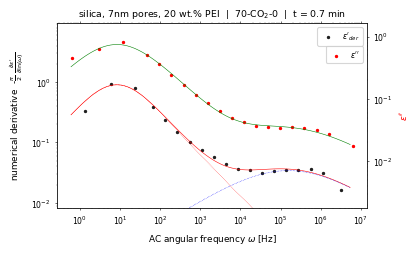

fit score 487137
fit parameters [2.593, 0.6659, 6.902, 0.1834, 0.4086, 140600.0, 1e-10, 1.0, 1e-10]


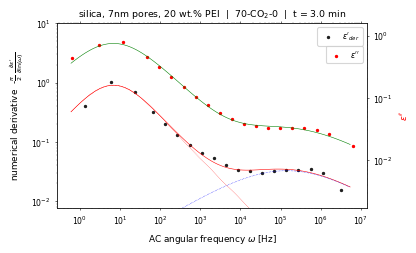

fit score 1345313
fit parameters [2.587, 0.6703, 5.09, 0.1815, 0.3877, 120200.0, 1e-10, 1.0, 1e-10]


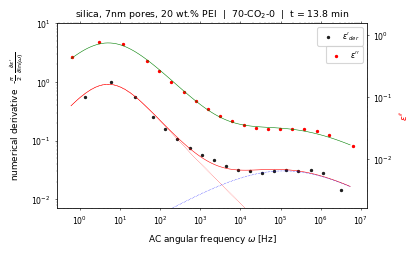

fit score 1624846
fit parameters [2.557, 0.6649, 4.434, 0.173, 0.3871, 120200.0, 1e-10, 1.0, 1e-10]


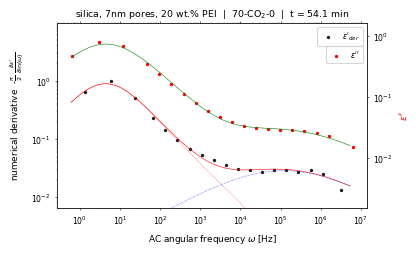

fit score 1576471
fit parameters [2.603, 0.6475, 3.67, 0.1602, 0.403, 120200.0, 1e-10, 1.0, 1e-10]


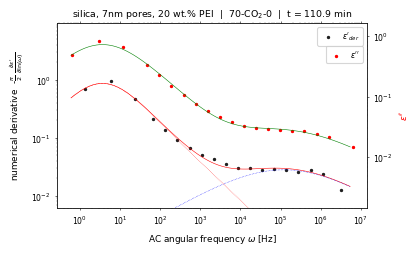

fit score 69927
fit parameters [2.38, 0.6273, 12.78, 0.1086, 0.5188, 279800.0, 3089000.0, 0.9608, 3.063e-08]


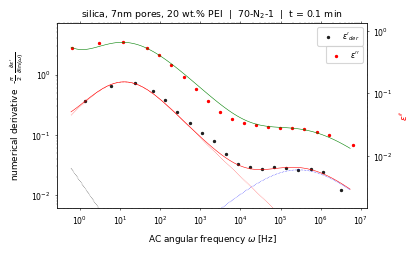

fit score 36306998
fit parameters [2.037, 0.7724, 213.0, 0.5622, 0.3084, 5608.0, 808100.0, 0.8446, 2.41e-07]


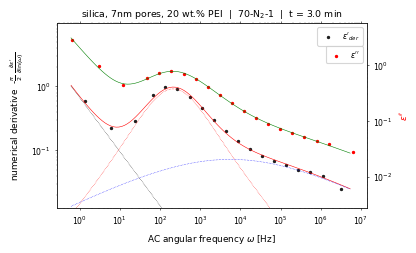

fit score 146227798
fit parameters [1.576, 0.7757, 508.0, 1.067, 0.3676, 4481.0, 6119000.0, 0.8028, 4.447e-08]


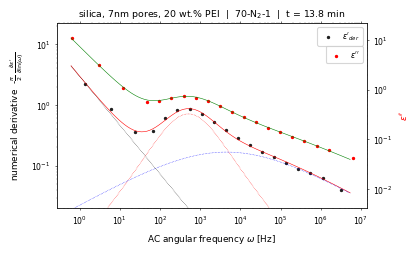

fit score 495358061
fit parameters [1.34, 0.7939, 781.6, 1.425, 0.3691, 5198.0, 22310000.0, 0.7768, 9.477e-09]


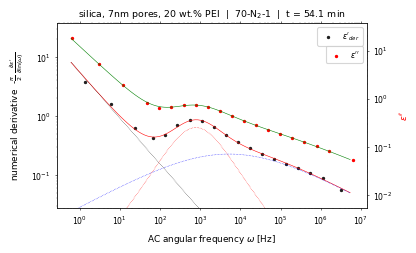

fit score 213424908
fit parameters [1.177, 0.8141, 856.6, 1.676, 0.3714, 3560.0, 24140000.0, 0.7616, 6.343e-09]


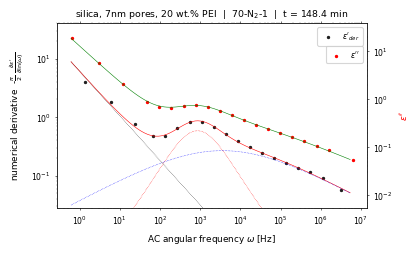

[2.603, 0.6473, 3.671, 0.16, 0.4036, 120200.0, 0.0, 1.0, 0.0]
2 476 ValueError :  array must not contain infs or NaNs
fit score 145725
fit parameters [2.686, 0.6629, 7.123, 0.1773, 0.4337, 132800.0, 1e-10, 1.0, 1e-10]


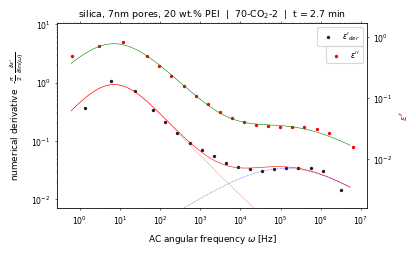

fit score 253362
fit parameters [2.685, 0.6617, 6.604, 0.1746, 0.4342, 130500.0, 1e-10, 1.0, 1e-10]


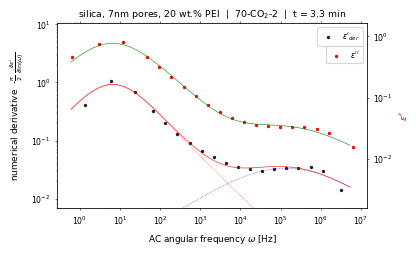

fit score 678107
fit parameters [2.701, 0.6584, 3.84, 0.1641, 0.4215, 110300.0, 1e-10, 1.0, 1e-10]


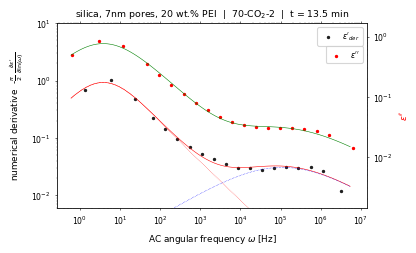

fit score 949561
fit parameters [2.687, 0.6495, 3.534, 0.1579, 0.4185, 110300.0, 1e-10, 1.0, 1e-10]


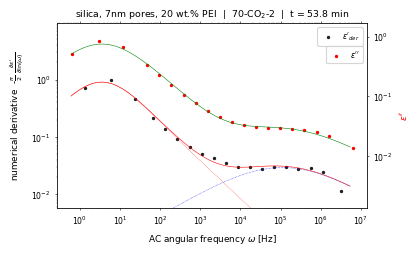

fit score 551771
fit parameters [2.747, 0.632, 2.939, 0.1462, 0.429, 110300.0, 1e-10, 1.0, 1e-10]


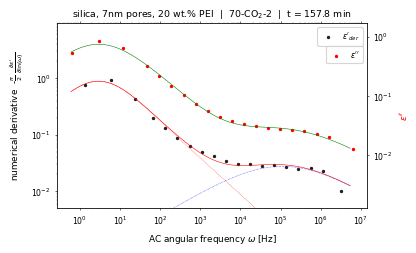

fit score 43449
fit parameters [2.319, 0.7231, 2.896, 1.317, 0.191, 1.016, 5900000.0, 0.9791, 9.927e-38]


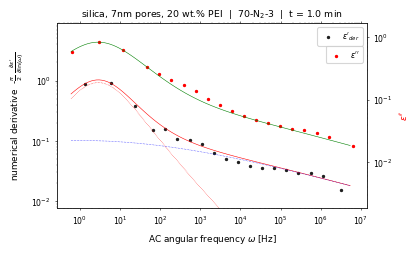

fit score 763791950
fit parameters [2.084, 0.7417, 164.6, 0.6945, 0.2515, 1288.0, 13.43, 0.9191, 0.105]


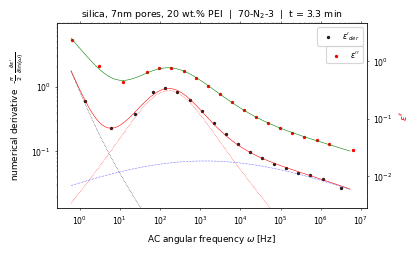

fit score 157839848
fit parameters [1.581, 0.762, 457.8, 1.1, 0.3486, 3121.0, 302.6, 0.749, 0.004596]


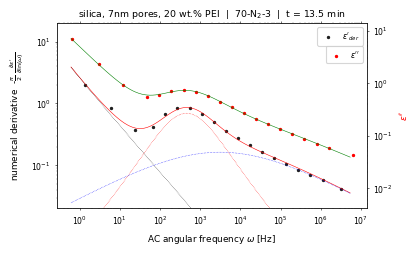

fit score 1009851241
fit parameters [1.301, 0.7958, 752.7, 1.502, 0.3591, 4098.0, 206400.0, 0.7459, 1.796e-06]


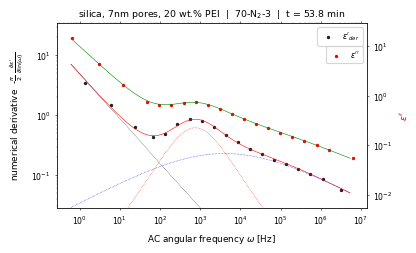

fit score 417548141
fit parameters [1.187, 0.8133, 890.0, 1.688, 0.3645, 3521.0, 3404000.0, 0.7491, 5.868e-08]


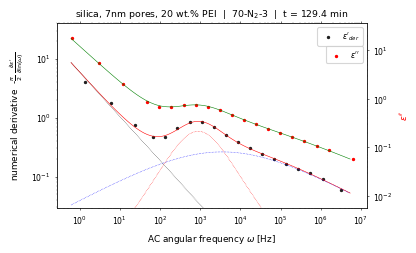

[1.322, 0.7562, 120.7, 0.6981, 0.3049, 1862.0, 59960000.0, 0.8623, 0.0]
1 19 ValueError :  array must not contain infs or NaNs
[1.322, 0.7562, 120.7, 0.6981, 0.3049, 1862.0, 59960000.0, 0.8623, 0.0]
1 20 ValueError :  array must not contain infs or NaNs
[1.322, 0.7562, 120.7, 0.6981, 0.3049, 1862.0, 59960000.0, 0.8623, 0.0]
1 21 ValueError :  array must not contain infs or NaNs
[1.322, 0.7562, 120.7, 0.6981, 0.3049, 1862.0, 59960000.0, 0.8623, 0.0]
1 22 ValueError :  array must not contain infs or NaNs
fit score 302506
fit parameters [1.913, 0.6383, 9.095, 0.181, 0.3589, 59690.0, 659100.0, 1.0, 2.289e-07]


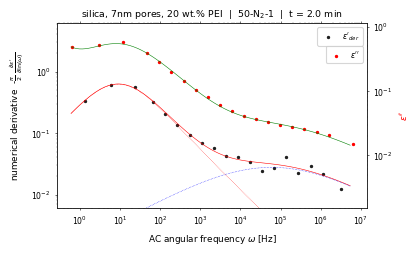

fit score 14223583
fit parameters [1.791, 0.7006, 13.44, 0.2697, 0.2926, 11460.0, 258700.0, 1.0, 7.851e-07]


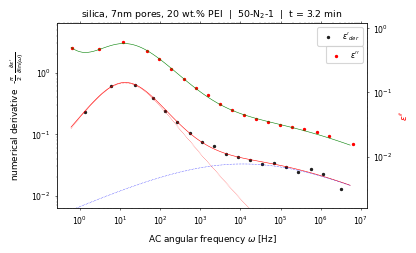

fit score 94158321
fit parameters [1.736, 0.7101, 27.0, 0.3427, 0.2623, 6249.0, 5703000.0, 0.9908, 5.45e-08]


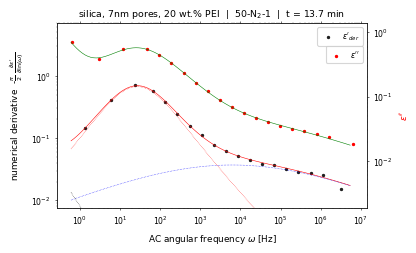

fit score 19585918
fit parameters [1.399, 0.7453, 90.2, 0.6478, 0.2658, 957.5, 68110000.0, 0.8969, 1.777e-09]


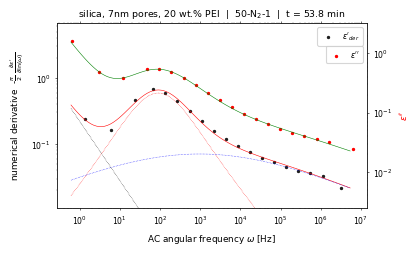

fit score 2010401
fit parameters [1.326, 0.7581, 118.7, 0.6906, 0.3055, 1863.0, 70080000.0, 0.8614, 1.24e-09]


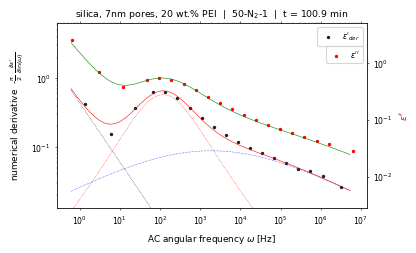

fit score 80802
fit parameters [0.451, 0.6658, 95.35, 0.1593, 0.3836, 46590.0, 3690.0, 0.5748, 1.786e-06]


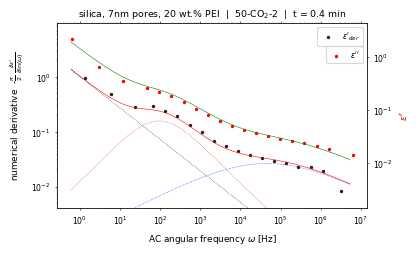

FALLBACK 2:  44085.753839588775
fit score 82778
fit parameters [0.0001716, 0.204, 230.1, 0.1663, 0.3259, 13470.0, 4242.0, 0.4845, 4.317e-08]


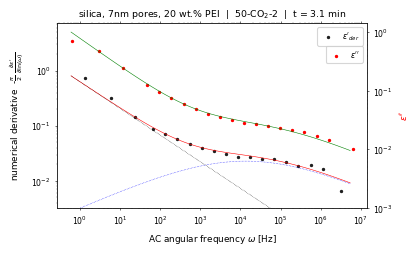

FALLBACK 2:  47022.053522682494
FALLBACK 2:  43951.9416052652
FALLBACK 2:  45756.565631594865
fit score 290992
fit parameters [0.1385, 0.3273, 2000.0, 0.02657, 0.6676, 225300.0, 4976.0, 0.5186, 5.408e-08]


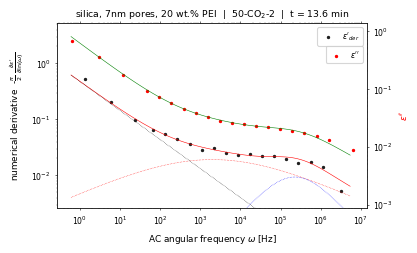

fit score 429669
fit parameters [0.1508, 0.3132, 2000.0, 0.02348, 0.7132, 264300.0, 10780.0, 0.5408, 2.46e-08]


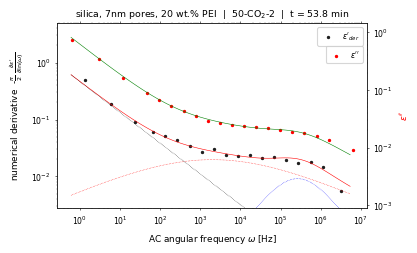

fit score 1014026
fit parameters [0.1589, 0.3049, 1987.0, 0.02126, 0.7484, 296600.0, 21890.0, 0.553, 9.942e-09]


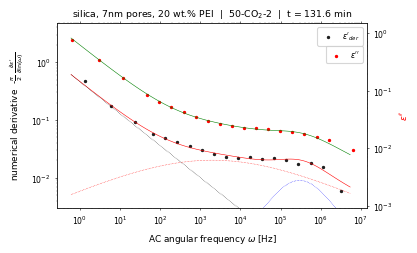

fit score 19081
fit parameters [0.747, 0.7346, 12.61, 0.1887, 0.3612, 9928.0, 47060000.0, 1.0, 1.099e-08]


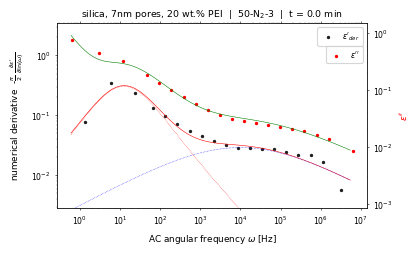

fit score 71081557
fit parameters [1.686, 0.7135, 13.29, 0.3056, 0.2666, 5441.0, 1652000.0, 1.0, 1.297e-07]


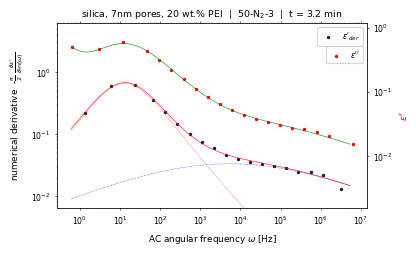

fit score 137025189
fit parameters [1.617, 0.7382, 25.27, 0.419, 0.2362, 1443.0, 390200.0, 1.0, 7.08e-07]


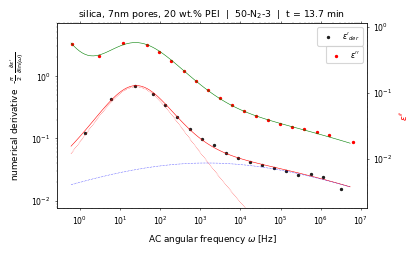

fit score 20288396
fit parameters [1.428, 0.7463, 78.99, 0.5932, 0.263, 1149.0, 13420000.0, 0.9032, 9.975e-09]


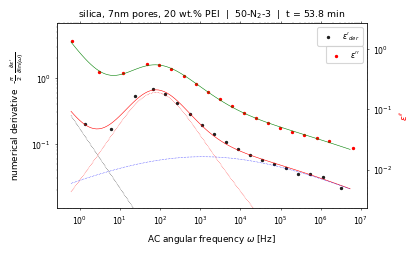

fit score 2611217818
fit parameters [1.886, 0.5892, 16.0, 0.4391, 0.3635, 15560.0, 28.75, 0.9988, 0.03158]


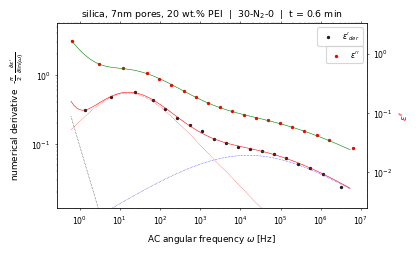

fit score 5842195225
fit parameters [1.905, 0.5815, 19.17, 0.4172, 0.3731, 23190.0, 15.96, 1.0, 0.07513]


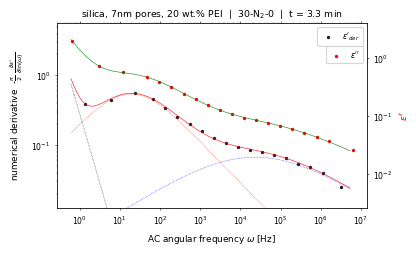

fit score 2894201187
fit parameters [1.9, 0.6058, 36.87, 0.4261, 0.3912, 41110.0, 13.58, 1.0, 0.187]


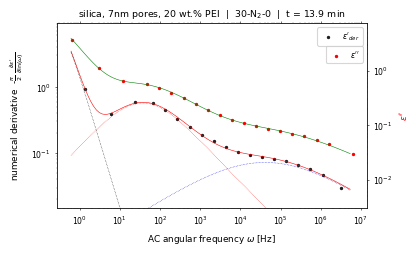

fit score 977983774
fit parameters [1.867, 0.6187, 68.39, 0.4043, 0.4107, 85650.0, 64.68, 0.923, 0.06549]


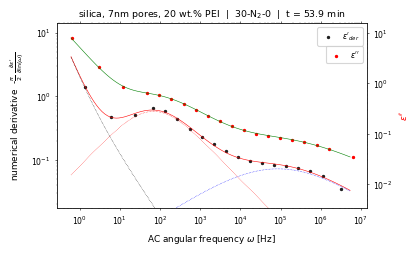

fit score 784506139
fit parameters [1.865, 0.6185, 68.8, 0.4032, 0.4105, 86950.0, 65.93, 0.9209, 0.06406]


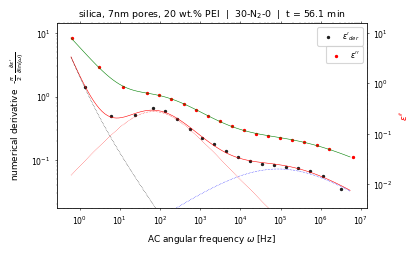

fit score 2292504
fit parameters [0.05477, 0.7891, 1307.0, 0.1304, 0.5281, 119700.0, 15020.0, 0.5229, 1.043e-08]


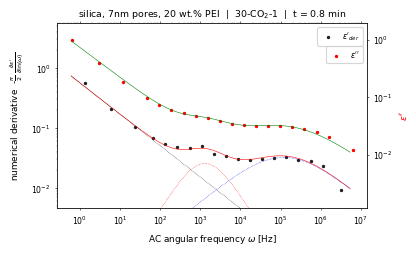

fit score 4253166
fit parameters [0.1217, 0.5386, 845.8, 0.09129, 0.6045, 208500.0, 23180.0, 0.5739, 1.769e-08]


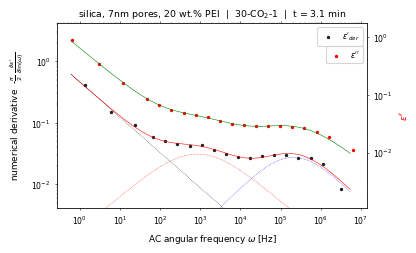

fit score 4220355
fit parameters [0.2465, 0.3083, 342.3, 0.03877, 0.7498, 298000.0, 52330.0, 0.6614, 3.974e-08]


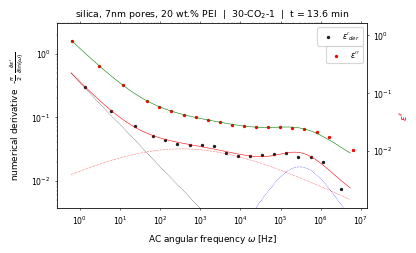

fit score 3430161
fit parameters [0.2569, 0.2863, 357.9, 0.02613, 0.8201, 370000.0, 7955.0, 0.7125, 2.029e-06]


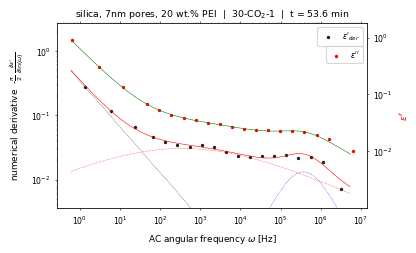

fit score 1800189
fit parameters [0.2816, 0.2696, 223.5, 0.02025, 0.8731, 419500.0, 10280.0, 0.7699, 4.427e-06]


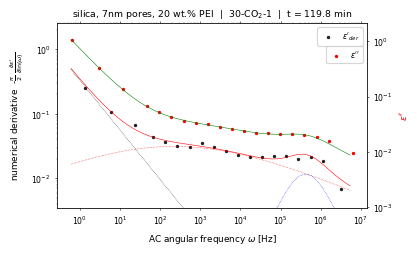

fit score 165609
fit parameters [0.5722, 0.7033, 5.243, 0.2803, 0.2668, 3405.0, 51440.0, 1.0, 1.3e-05]


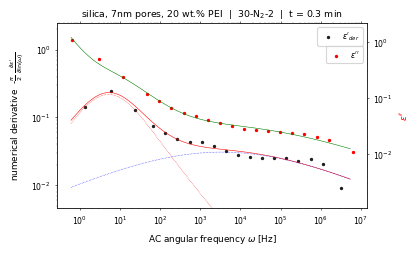

fit score 1014053
fit parameters [1.956, 0.6245, 1.72, 0.2674, 0.2795, 9606.0, 16070.0, 1.0, 2.541e-05]


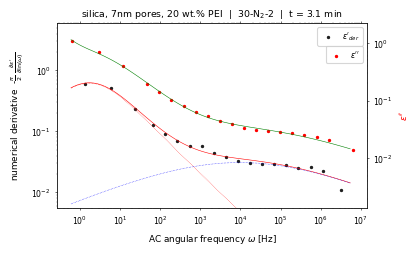

fit score 2304222
fit parameters [1.952, 0.6399, 3.077, 0.2504, 0.2968, 17290.0, 13350.0, 1.0, 2.272e-05]


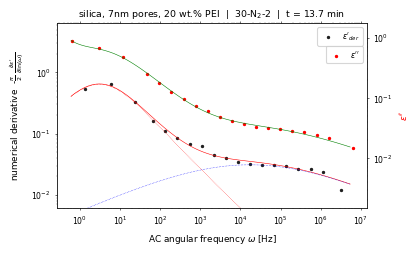

fit score 10104571
fit parameters [1.792, 0.6674, 7.225, 0.312, 0.263, 12000.0, 19600.0, 1.0, 1.932e-05]


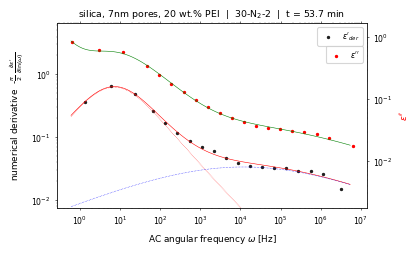

fit score 17803899
fit parameters [1.72, 0.6931, 13.44, 0.3803, 0.2432, 7052.0, 76110.0, 1.0, 7.535e-06]


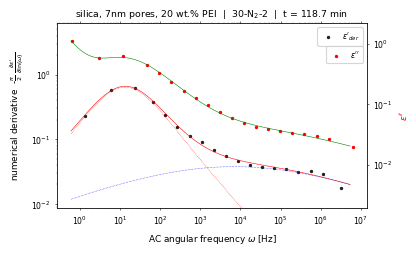

fit score 939666
fit parameters [0.1031, 0.5521, 1066.0, 0.07295, 0.5757, 235500.0, 22750.0, 0.6064, 7.279e-08]


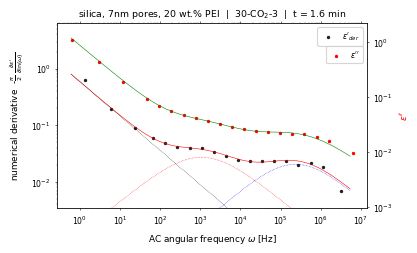

fit score 1776581
fit parameters [0.2199, 0.3134, 926.6, 0.01991, 0.8775, 436600.0, 36640.0, 0.649, 7.987e-08]


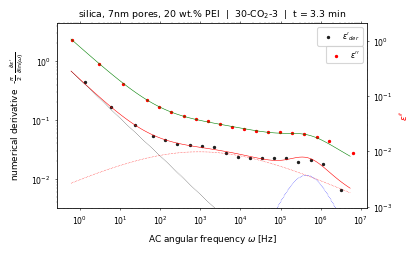

fit score 2052547
fit parameters [0.2431, 0.2976, 457.0, 0.02043, 0.8676, 421000.0, 45440.0, 0.6969, 1.476e-07]


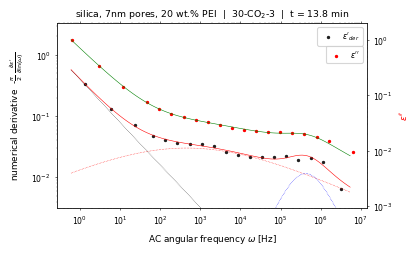

fit score 1461234
fit parameters [0.2738, 0.278, 256.4, 0.01897, 0.8906, 450100.0, 10670.0, 0.7604, 4.082e-06]


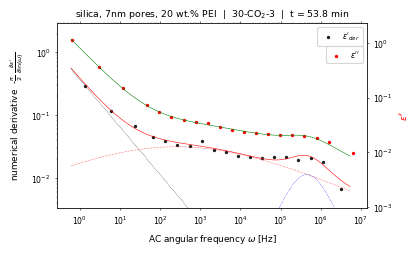

fit score 2807092
fit parameters [0.2922, 0.2634, 178.2, 0.01755, 0.9007, 459200.0, 14670.0, 0.7877, 4.303e-06]


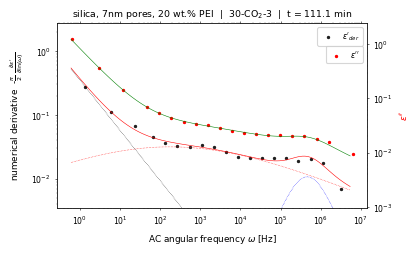

fit score 392865
fit parameters [2.758, 0.4278, 0.222, 0.1216, 0.424, 121500.0, 27600.0, 1.0, 2.085e-05]


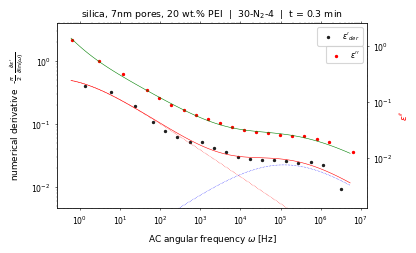

fit score 1463975
fit parameters [1.922, 0.606, 3.449, 0.2484, 0.2942, 19690.0, 26930.0, 1.0, 2.178e-05]


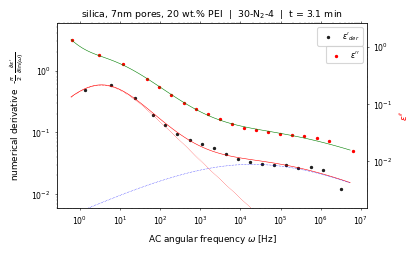

fit score 3561764
fit parameters [1.876, 0.6384, 7.48, 0.2736, 0.2883, 22680.0, 50670.0, 1.0, 1.302e-05]


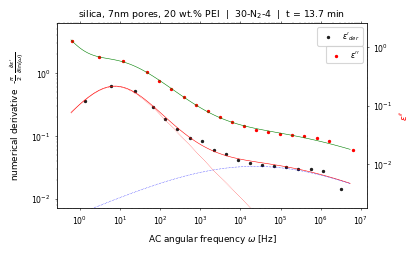

fit score 6537874
fit parameters [1.807, 0.6616, 11.25, 0.3028, 0.2762, 18790.0, 205900.0, 1.0, 3.192e-06]


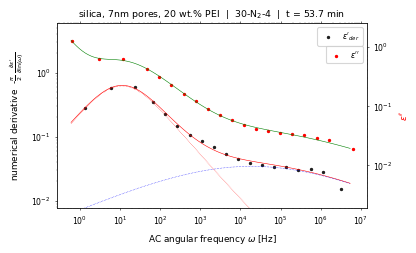

fit score 11273233
fit parameters [1.778, 0.676, 14.39, 0.3414, 0.2604, 12770.0, 23700000.0, 1.0, 3.202e-08]


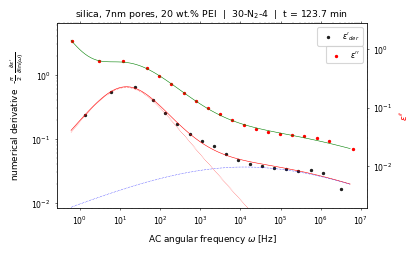

In [6]:
### main

# ignore these runs: "tr", where t represents the temperature ({0, 1, 2} -> {70, 50, 30})  and r is the number of the run
idOut = ["10"]
# selection of a few indices where the plot is shown; quadratic: show many at the start and less later
plotI = np.linspace(0,4,4)
plottimes = np.exp( plotI )-1
plottimes = np.append(plottimes, [1e5, 1e5])
# ignore last tol minutes of each run to avoid faulty data from next run
tol = 5

# combined lists that save the fit data, will contain numpy arrays of different length, one array per run
P_ALL = []
DT_ALL = []
A_ALL = []
# save ID for easier handling, P_ALL[j] will correspond to ID[j]
# ID is temperature-gas-run ie. "70-N_2-1", as shown in plots
ID = []

# go throgh all temperatures, or rather their respective datasets
for m, data in enumerate(DATA) :
    temp = str(TEMPS[m])

    # f is an array of the unique frequencies
    # er_der is a 2D array of all "numerical derivative of real part"-values
    # er_der[i] (one row of the matrix) is one spectrum
    # where i (one column) corresponds to the time
    # The array contains a whole measurement with fixed temperature and all gas runs
    f, er_der, ei, t = process_and_compute_derivative(data)
    ln_er_der = np.log(er_der)
    w = 2*np.pi*f
    lnw = np.log(w)
    lnw_der = (lnw[:-1] + lnw[1:]) / 2
    w_der = np.exp(lnw_der)
    
    # go throgh all runs, one run starts with change of gas
    for j, t0 in enumerate(GASCHANGE[m][:-1]) :
        if str(m)+str(j) in idOut :
            continue
        gas = GASES[S[m][j]]
        ID.append(temp+'-'+gas+'-'+str(j))
        run_num = len(ID) - 1

        t1 = GASCHANGE[m][j+1]-tol
        # indices of start/end of current run
        t0_i = np.searchsorted(t, t0, side="left")
        t1_i = np.searchsorted(t, t1, side="right")

        p0 = p0_start[run_num]
        # stack of numpy arrays of all fit parameters of current run: [ [a,b,c,...], [a,b,c,...], ... ]
        PARAMS = []
        # stack of times; needed because fit doesn't always converge. DT[i] corresponds to PARAMS[i]
        DT = []
        A = []

        plot_i = 0
        for i in range(t0_i, t1_i) :
            # time relative to change of gas (=start of current run)
            dt = t[i]-t0

            # if the fit converged, p0 (next initial guess) will be the optimal parameters   
            p0, a, fitscore = fit(lnw_der, ln_er_der[i], lnw, np.log(ei[i]), p0, run_num)
            #p0 = fixorder(p0)

            if fitscore > 17000 :
                # save fit parameters and time if the fit was successful
                PARAMS.append(p0)
                A.append(a)
                DT.append(dt)

                # plot a small selection of spectra
                if dt > plottimes[plot_i] or i==t1_i-1 :
                    plot(w_der, er_der[i], w, ei[i], p0, dt, run_num, ID[-1], fitscore)
                    plot_i += 1


        # after processing whole run: save all the fit data of the run in big combined list
        # swap axes of PARAMS, such that the colums-rows are times-fit parameters
        P = np.swapaxes(PARAMS, 0, 1)
        P_ALL.append(P)
        DT_ALL.append(np.array(DT))
        A_ALL.append(np.array(A))

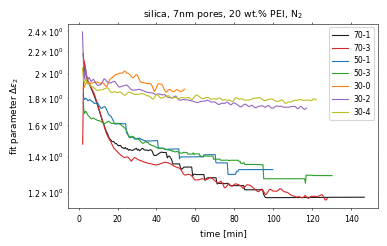

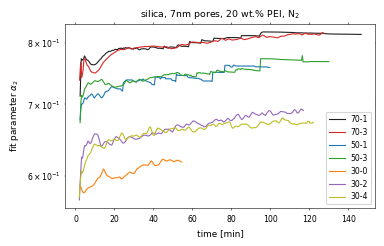

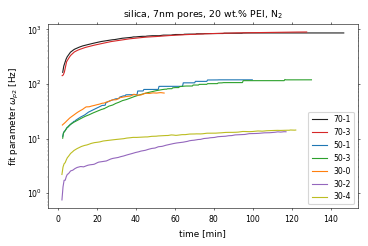

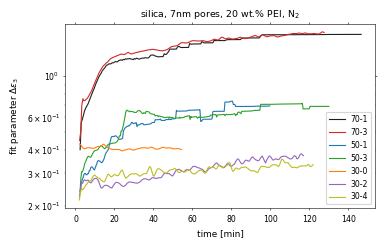

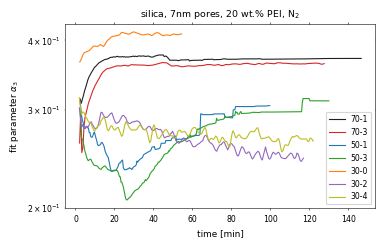

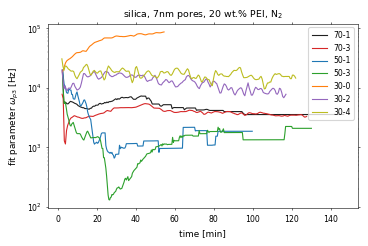

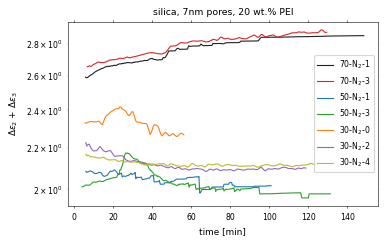

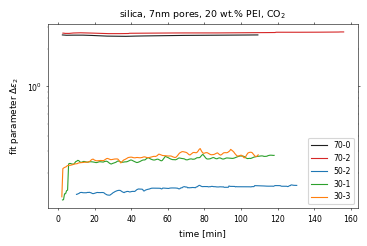

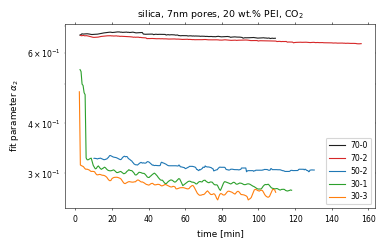

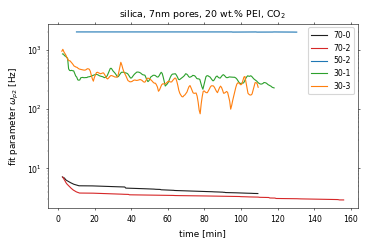

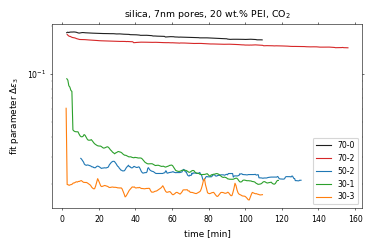

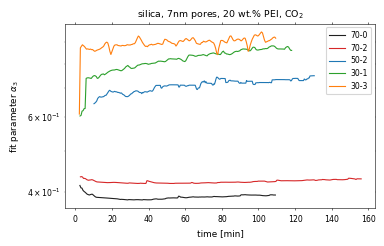

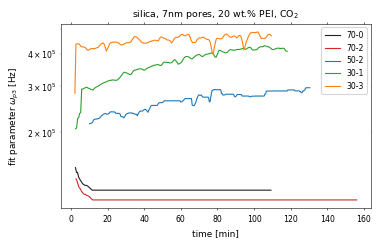

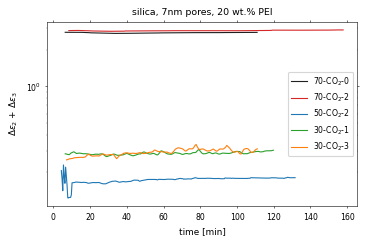

In [7]:
### Plot time evolution of fit parameters

p_labels = ["$\\Delta\\epsilon_2$", "$\\alpha_2$", "$\\omega_{p2}$ [Hz]", 
            "$\\Delta\\epsilon_3$", "$\\alpha_3$", "$\\omega_{p3}$ [Hz]", 
            "$\\Delta\\epsilon_3$", "$\\alpha_3$", "$\\omega_{p3}$ [Hz]"]

# j: run with specific temp and gas
# i: parameters

good = [DT_ALL[j] > 2 for j in range(len(DT_ALL))]
good = [np.append(good[j][:-3], [False, False, False]) for j in range(len(DT_ALL))]
DT_ALL_ = [DT_ALL[j][good[j]] for j in range(len(DT_ALL))]
P_ALL_ = [P_ALL[j][:, good[j].flatten()] for j in range(len(DT_ALL))]

p_in = [0, 2, 3, 5, 6, 8]

for gas in GASES :
    for i, parameter in enumerate(p_labels[:-3]) :
        plt.xscale('linear')
        plt.yscale('log')

        #l, u = 1e50, -1

        for j, id in enumerate(ID) :
            if id[3] != gas[0] :#or (id[0]=='3' and id[-1]=='0') :
                continue
            if id[3] == "C" and id[0] == "5":
                n = 20
            else :
                n = 0
            #if id[0] == "7" and id[-1] == "2" :
            #    continue
            label = id[:2] + id[-2:]

            x, y = DT_ALL_[j][n:], P_ALL_[j][i][n:]
            #lower_threshold, upper_threshold = np.percentile(y, [5, 95])
            #l, u = min(lower_threshold, l), max(upper_threshold, u)

            plt.plot(x, y, label=label, linewidth=1)
            plt.title(SAMPLE + ", " + gas)

        plt.xlabel("time [min]")
        plt.ylabel("fit parameter " + parameter)
        plt.legend()
        #plt.savefig("results20/paramkin/"+gas+" "+parameter+".png", bbox_inches='tight')
        plt.show()

    plt.xscale('linear')
    plt.yscale('log')

    for j, id in enumerate(ID) :
        if id[3] != gas[0] :#or (id[0]=='3' and id[-1]=='0') :
            continue
        de_sum = P_ALL[j][0] + P_ALL[j][3]
        plt.plot(DT_ALL[j][10:], de_sum[10:], label=id, linewidth=1)
        plt.title(SAMPLE)

    plt.xlabel("time [min]")
    plt.ylabel(p_labels[0] + " + " + p_labels[3])
    plt.legend()
    plt.show()

NameError :  name 'skdfjsio' is not defined
NameError :  name 'skdfjsio' is not defined


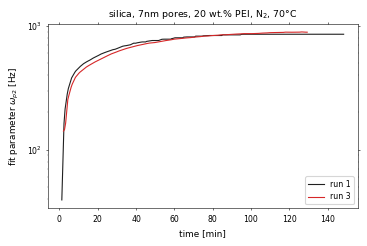

NameError :  name 'skdfjsio' is not defined
NameError :  name 'skdfjsio' is not defined


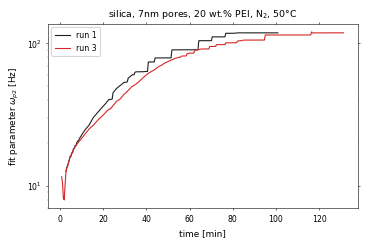

NameError :  name 'skdfjsio' is not defined
NameError :  name 'skdfjsio' is not defined
NameError :  name 'skdfjsio' is not defined


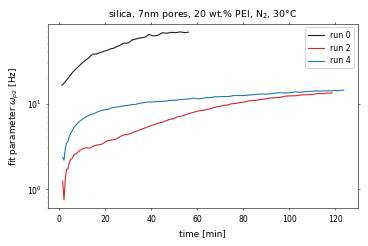

In [8]:
### parameters by temperature

def exp(x, a, b, c) :
    return np.exp(-b*(x-a)) + c

for i, parameter in enumerate(p_labels[:-3]) :
    if i != 2 :
        continue

    for temperature in TEMPS :
        temp = str(temperature)

        plt.xscale('linear')
        plt.yscale('log')

        for j, id in enumerate(ID) :
            if id[3] != "N" or id[0] != temp[0] :#or (id[0]=='3' and id[-1]=='0') :
                continue
            label = "run " + id[-1]
            t, p = DT_ALL[j][2:], P_ALL[j][i][2:]
            #n = np.argmin(a)
            #t, a = t[n:], a[n:]
            plt.plot(t, p, label=label, linewidth=1)
            fitt1 = t < 10
            fitt2 = t > 15

            fitf = exp
            try :
                ldgnd = skdfjsio
                popt1, _ = curve_fit(fitf, t[fitt1], a[fitt1], bounds=((0., 0., 0.), (i_, i_, i_)))
                popt2, _ = curve_fit(fitf, t[fitt2], a[fitt2], bounds=((0., 0., 0.), (i_, i_, i_)))

                y1 = fitf(t, *popt1)
                y2 = fitf(t, *popt2)
                #yp = expp(DT, *popt[:3])
                #yn = expn(DT, *popt[2:])
                plt.plot(t, y1, linewidth=0.5, color='b')
                plt.plot(t, y2, linewidth=0.5, color='g')
                #plt.plot(DT, yp)
                #plt.plot(DT, yn)
            except Exception as err :
                print(str(type(err))[8:-2], ": ", err)

            plt.title(SAMPLE + ", " + id[3:-2] + ", " + temp + "°C")

        plt.xlabel("time [min]")
        plt.ylabel("fit parameter " + parameter)
        plt.legend()
        #plt.savefig("results20/omegaevo/"+gas+" "+temp+".png", bbox_inches='tight')
        plt.show()

70
[2.21699686e+02 2.49643584e+01 1.75946988e+04 4.50167480e+00
 4.10148390e+01]
70
[2.92392512e+02 3.30023716e+01 1.79764481e+04 5.56877809e+00
 5.10955217e+01]


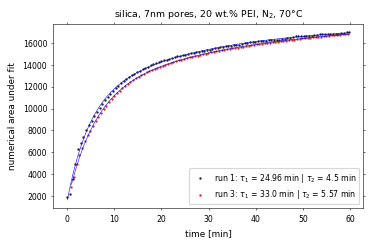

50
[ -265.41814086   264.50609859 15095.48153443   264.6273168
  2504.3414494 ]
50
RuntimeError :  Optimal parameters not found: The maximum number of function evaluations is exceeded.


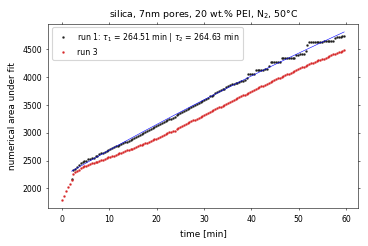

30
[  86.71125127   12.06012928 6286.68003826   25.94966998 -791.92283381]
30
RuntimeError :  Optimal parameters not found: The maximum number of function evaluations is exceeded.
30
[1.50364629e+01 2.43104932e+00 2.61572099e+03 1.94783559e+01
 1.12434092e+02]


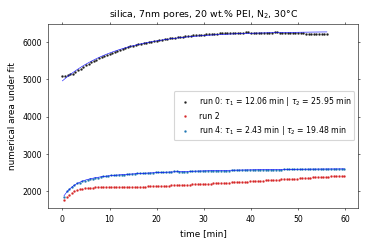

70
[  13.43626888    2.49960244 1912.34584625   15.5671351    86.67691185]
70
[  12.38694316    1.98961255 1916.06847429    7.71811848   44.89837983]


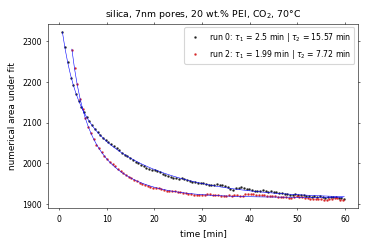

50
[2.47476589e+00 3.42104155e-01 1.32737620e+03 5.26595259e+00
 3.37605781e+01]


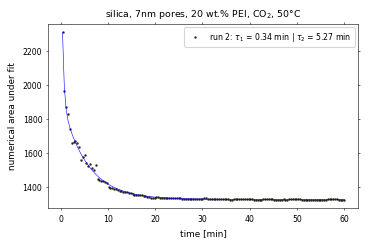

30
[  94.9696145    16.59222613 1383.534286      1.82034356   10.93272997]
30
RuntimeError :  Optimal parameters not found: The maximum number of function evaluations is exceeded.


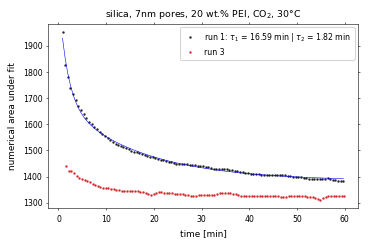

In [9]:
### Plot area

def exp(x, a, b, c, d, e) :
    return np.exp(-(x-a)/b) + c + np.exp(-(x-e)/d)
def expn(x, a, b, c, d, e) :
    return -np.exp(-(x-a)/b) + c - np.exp(-(x-e)/d)

p01 = [[3.13982775e+02, 3.54885096e+01, 1.81290828e+04, 5.70343000e+00, 5.24520412e+01],
    [1.18472451e+01, 1.11436920e+00, 1.98973972e+05, 6.78821372e+01, 7.78590720e+02],
    [1.50365926e+01, 2.43106947e+00, 2.61572150e+03, 1.94785320e+01, 1.12435019e+02]]
p02 = [[  13.43631687,    2.49961102, 1912.34579601,   15.56716046,   86.67703241],
    [2.47479126e+00, 3.42108290e-01, 1.32737618e+03, 5.26595996e+00, 3.37606163e+01],
    [  94.96847939,   16.59200303, 1383.53486793,    1.82029623,  10.93245541]]

for gas in GASES :
    for T_i, temperature in enumerate(TEMPS) :
        temp = str(temperature)

        plt.xscale('linear')
        plt.yscale('linear')

        for j, id in enumerate(ID) :
            if not (id[3] == gas[0] and id[0] == temp[0]) :#or (id[0]=='3' and id[-1]=='0') :
                continue
            label = "run " + id[-1]
            print (temp)
            t, a = DT_ALL[j], A_ALL[j]
            fitt = t < 60
            t, a = t[fitt], a[fitt]


            if id[3] == "N" :
                fitf = expn
                p0 = p01[T_i]
            else :
                fitf = exp
                p0 = p02[T_i]
            try :
                popt, _ = curve_fit(fitf, t, a, p0=p0, bounds=((-i_, 0, 0., 0, -i_), (i_, i_, i_, i_, i_)))
                print(popt)
                plt.plot(t, fitf(t, *popt), color="b")

                tau1 = np.round(popt[1],2)
                tau2 = np.round(popt[3],2)
                label = label + f': $\\tau_1$ = {tau1} min | $\\tau_2$ = {tau2} min'

                y1 = fitf(t, -i_, *popt[1:])
                y2 = fitf(t, *popt[:-1], -i_)
                #plt.plot(t, y1, linewidth=1, color='b', ls=":")
                #plt.plot(t, y2, linewidth=1, color='g', ls=":")
            except Exception as err :
                print(str(type(err))[8:-2], ": ", err)

            plt.scatter(t, a, label=label, linewidth=0.1)
            plt.title(SAMPLE + ", " + gas + ", " + temp + "°C")

        plt.xlabel("time [min]")
        plt.ylabel("numerical area under fit")
        plt.legend()
        #plt.savefig("results20/areaevo/"+gas+" "+temp+"2.png", bbox_inches='tight')
        plt.show()

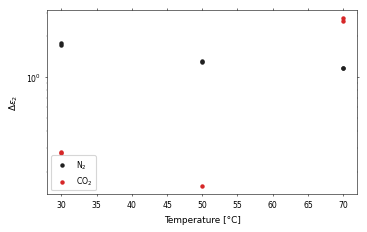

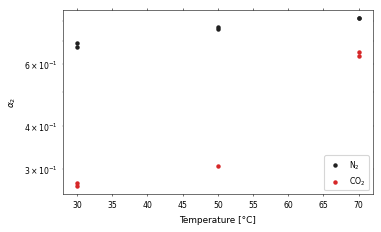

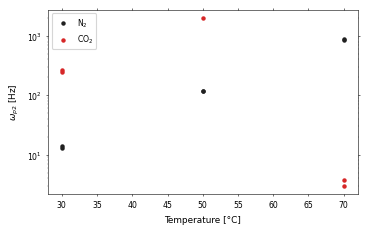

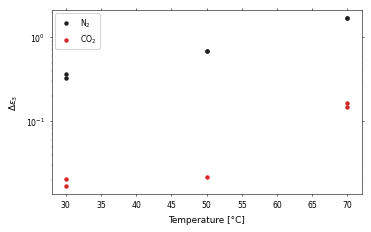

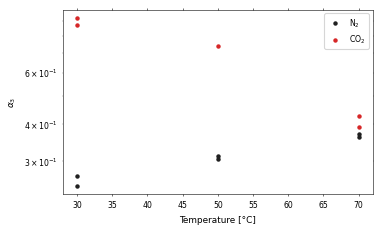

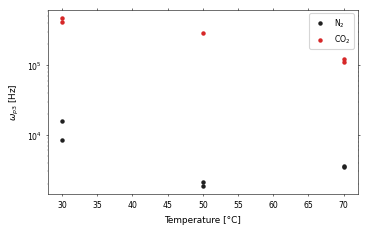

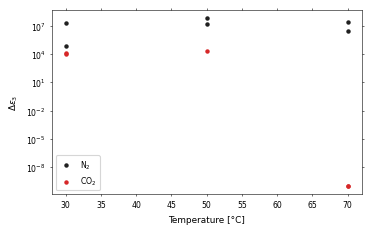

In [10]:
### plot final fit parameters against temperature

look_at = range(0,7)

for p in look_at :
    plt.yscale('log')

    for gas in GASES :
        values = []
        for j, id in enumerate(ID) :
            if not id[3] == gas[0] or (id[0]=='3' and id[-1]=='0') :
                continue
            x = P_ALL_[j][p][-20:]
            xa = np.average(x)
            xe1 = xa - np.min(x)
            xe2 = np.max(x) - xa
            xe1 = xe1 * (xe1 > 0)
            xe2 = xe2 * (xe2 > 0)
            values.append(np.array([int(id[:2]), xa, xe1, xe2]))
        v = np.swapaxes(values, 0, 1)

        plt.scatter(v[0], v[1], linewidths=2, label=gas)
        #plt.errorbar(v[0], v[1], yerr=v[2:], fmt='none')

    plt.xlabel("Temperature [°C]")
    plt.ylabel(p_labels[p])
    plt.legend()
    plt.show()
